# Toy resonant neuron model

Maybe SOM neurons have a subthreshold resonance or extra low-pass filter due to IA that isn't readily captured by the GIF. Could try implementing a resonating GIF, but would need to know how exactly the resonating current might be fitted.

This notebook provides a proof of concept of how a resonating current with a fixed $\tau$ can capture high- or low-pass frequency filtering effects.

## Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Define toy model

Define a simple model to illustrate the effect of changing the sign of a voltage-independent resonating current.
Dynamics of the model are given by $$C \frac{dV}{dt} = -g_l (V(t) - E_l) + aw + I(t),$$ where $$ \tau_{res} \frac{dw}{dt} = (V(t) - E_l) - w. $$

In [2]:
class toyResMod(object):
    """Toy model with voltage-independent resonance.
    """
    
    def __init__(self, gl, El, C, tau_res, a, thresh = -45., Vreset = -55., dt = 0.1):
        
        self.gl = gl # Leak conductance (nS)
        self.El = El # Equilibrium potential for leak (mV)
        self.C = C   # Cell capacitance (nF)
        
        self.tau_res = tau_res # Time constant of resonating current (ms).
        self.a = a             # Magnitude of resonating current.
        
        self.thresh = thresh   # Spike threshold (mV).
        self.Vreset = Vreset   # Post-spike voltage reset (mV).
        
        self.dt = dt # Simulation timestep (ms)
        
        # Initialize simulation-related attributes.
        self._sim_flag = False # Flag to know whether a simulation has been run yet.
        self.t = None
        self.I = None
        self.V = None
        self.w = None
        self.spks = None
        
    def simulate(self, I, V0):
        """Simulate neuron response to input current I (nA) given a starting voltage V0 (mV).
        """
        
        # Allocate vectors to store output.
        V = np.zeros_like(I)
        w = np.zeros_like(I)
        spks = []
        
        # Set initial condition.
        V[0] = V0
        w[0] = 0
        
        # Iterate over time.
        for t in range(1, len(I)):
            
            # Integrate w
            dw = ((V[t-1] - self.El) - w[t-1]) / self.tau_res
            w[t] = w[t-1] + dw * self.dt
            
            # Integrate V
            dV = (-self.gl * (V[t-1] - self.El) - self.a * w[t-1] + I[t-1]) / self.C
            V[t] = V[t-1] + dV * self.dt
            
            if V[t] > self.thresh:
                V[t] = self.Vreset
                spks.append(t)
                
        # Add attributes to save simulation results
        self._sim_flag = True
        self.t = np.arange(0, (len(I) - 0.5) * self.dt, self.dt)
        self.I = I
        self.V = V
        self.w = w
        self.spks = spks
                
        # Return API should be consistent with GIFs.
        return self.t, V, None, None, spks, w
    
    
    def plot(self):
        """Generate quick plot of simulation.
        """
        
        if not self._sim_flag:
            raise AttributeError('No simulation to plot!')
        
        plt.figure()
        
        plt.subplot(311)
        plt.plot(self.t, self.V, 'k-')
        plt.ylabel('V (mV)')

        plt.subplot(312)
        plt.plot(self.t, self.w, 'k-')
        plt.ylabel('w')

        plt.subplot(313)
        plt.plot(self.t, self.I, '-', color = 'gray')
        plt.ylabel('I (nA)')
        plt.xlabel('Time (ms)')

        plt.tight_layout()

        plt.show()

## Illustrative simulations

### Instantiate models and run simulations

Construct a set of models with $a = 0$, $a > 0$, or $a < 0$ and simulate response to a chirp current.

In [3]:
mod_params = {'gl': 0.001, 'El': -70., 'C': 0.2, 'tau_res': 50, 'dt': 0.1}

mods = {
    'base': toyResMod(a = 0., **mod_params),
    'posa': toyResMod(a = 5 * mod_params['gl'], **mod_params),
    'nega': toyResMod(a = -mod_params['gl'], **mod_params)
}

In [4]:
T = 30000
I = 0.0005 * np.sin(
    2 * np.pi * np.linspace(0.0005, 0.05, int(T/mod_params['dt'])) 
        * np.arange(0, T, mod_params['dt']) * mod_params['dt']
)

for key, mod in mods.iteritems():
    mod.simulate(I, mod.El)

### Inspect results

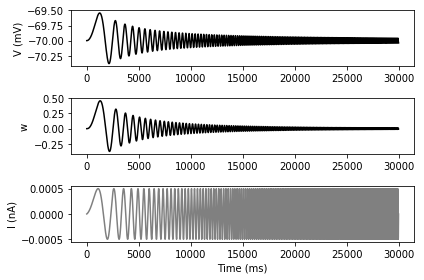

In [5]:
mods['base'].plot()

Response of a simple model with $a = 0$ to a chirp stimulus. Note low-pass filtering effect.

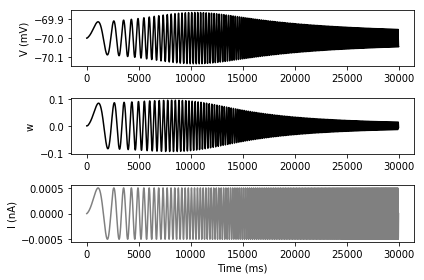

In [6]:
mods['posa'].plot()

Same stimulus, but this time $a > 0$. Note resonance.

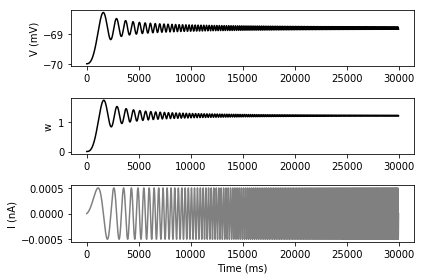

In [7]:
mods['nega'].plot()

Finally, a model in which $a < 0$. Now the current seems to modify the resting membrane potential and add an extra low-pass component to the membrane filter.